# Image Captioning with Attention

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Download and extract the Flickr8k dataset from Kaggle

In [ ]:
# Download and extract the Flickr8k dataset from Kaggle
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98%|██████████████████████████████████████▎| 1.02G/1.04G [00:04<00:00, 295MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:04<00:00, 260MB/s]


In [2]:
import zipfile
import os

zip_path = "/kaggle/working/flickr8k.zip"  # Path to your ZIP file
extract_folder = "/kaggle/working/flickr8k"  # Folder to extract files into

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the extracted files
os.listdir(extract_folder)

['Images', 'captions.txt']

## 1. Import Libraries and Set Up Environment

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Embedding, LSTM, Input, add, Reshape, concatenate, Dropout, Attention, BatchNormalization,Lambda)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textwrap import wrap

## 2. Load the Dataset

loading the captions from the text file and set the paths for images and captions.

In [4]:
# Paths to image and captions datasets
image_path = '/kaggle/working/flickr8k/Images'
captions_path = '/kaggle/working/flickr8k/captions.txt'

In [5]:
# Set visualization style and suppress warnings
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv('/kaggle/working/flickr8k/captions.txt')

## 3. Preprocessing Functions

Here I defined helper functions:
 - **readImage:** Resizes, normalizes, and converts an image to an array.
 - **display_images:** Displays a grid of images along with their captions.
 - **preprocess_caption:** Cleans and formats the caption text.
 - **text_preprocessing:** Applies the caption preprocessing to the entire dataset.

In [7]:
# Function to preprocess images: resize, normalize, and convert to array
def readImage(path, img_size=224):
    img = load_img(path, target_size=(img_size, img_size))  # Resize to target size
    img = img_to_array(img)  # Convert to NumPy array
    img = img / 255.0  # Normalize pixel values
    return img


In [8]:
# Function to display images with their captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")  # Read image
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))  # Wrap long captions
        plt.axis("off")
    plt.show()

In [9]:
# Function to preprocess captions
def preprocess_caption(caption):
    if not isinstance(caption, str):
        return ""  # treat non-strings as empty captions
    caption = caption.lower()
    caption = re.sub(r'[^a-zA-Z]', ' ', caption)  # removed special characters
    caption = "start " + caption + " end"
    return caption

In [10]:
# Text preprocessing: clean and format captions
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(preprocess_caption)
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)  # Remove extra spaces
    data['caption'] = data['caption'].apply(
        lambda x: " ".join([word for word in x.split() if len(word) > 1 and isinstance(x, str)])
    )  # Keep words longer than one character
    return data

In [ ]:
# Applying text preprocessing to captions
data = text_preprocessing(df)

## 4. Tokenization and Dataset Splitting

tokenize the captions, create a vocabulary, and determine the maximum caption length.
Then, I split the data into training and validation sets.

In [12]:
# Tokenize captions and create a vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])
vocab_size = len(tokenizer.word_index) + 1  # Include padding token
max_length = max(len(caption.split()) for caption in data['caption'])

In [13]:
# Split data into training (75%) and validation (25%) sets
images = data['image'].unique().tolist()
n_images = len(images)
split_index = round(0.75 * n_images)
train_images = images[:split_index]
val_images = images[split_index:]

In [14]:
# Filter dataframes for train and validation datasets
train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

## 5. Feature Extraction using ResNet50

Using a pre-trained ResNet50 model (with ImageNet weights) to extract features from the images.
This serves as our visual feature representation for caption generation.

In [ ]:
# Loading the pre-trained ResNet50 model for feature extraction
model = ResNet50(weights="imagenet", include_top=False, pooling='avg') 
features = {}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Extract features for all unique images
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    feature = model.predict(img, verbose=0)  # Extract features
    features[image] = feature

100%|██████████| 8091/8091 [09:10<00:00, 14.69it/s]


## 6. Load GloVe Embeddings


Loading pre-trained GloVe embeddings and create an embedding matrix that maps our vocabulary words
to their corresponding embedding vectors.

In [17]:
# Load GloVe embeddings
def load_glove_embeddings(file_path, tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create an embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [ ]:
# Load GloVe embeddings
embedding_matrix = load_glove_embeddings('/kaggle/input/gloveem/glove.6B.300d.txt'a, tokenizer)

## 7. Custom Data Generator


To efficiently feed data into the model during training, I define a custom data generator.
This generator creates input-output pairs for each caption sequence.

In [19]:
# Custom data generator for feeding data into the model
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        return self.__get_data(batch)

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            img_feature = self.features[row[self.X_col]][0]
            caption = row[self.y_col]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(img_feature)
                X2.append(in_seq)
                y.append(out_seq)
        return (np.array(X1), np.array(X2)), np.array(y)

## 8. Building the Image Captioning Model with Attention


Constructing our model using:
 - **ResNet50 features:** Processed by a dense layer and batch normalization.
 - **GloVe embeddings:** For the captions, processed through two LSTM layers.
 - **Attention mechanism:** To focus on relevant parts of the image when generating captions.
 - **Additional LSTM and Dense layers:** For final caption prediction.

 
 Note: I include a custom Lambda layer to expand the dimensions of image features.


In [ ]:
# Define the image captioning model with attention
input1 = Input(shape=(2048,))  # ResNet50 output shape
input2 = Input(shape=(max_length,))
# Process image features
img_features = Dense(256, activation='relu')(input1)
img_features = BatchNormalization()(img_features)  # Batch normalization
# Process text (captions) with GloVe embeddings
sentence_features = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input2)  # GloVe embeddings


In [ ]:
# LSTM to process the sentence features
lstm_out = LSTM(256, return_sequences=True)(sentence_features)
lstm_out = LSTM(256, return_sequences=True)(lstm_out)  # Additional LSTM layer

# Process text (captions) with GloVe embeddings
def expand_dims_layer(x):
    return tf.expand_dims(x, axis=1)
# Use Lambda layer to expand dimensions of img_features
img_features_expanded = Lambda(expand_dims_layer, output_shape=(1, 256))(img_features)
# img_features_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(img_features)
# img_features_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=(1, 256))(img_features)

# Attention mechanism
attention = Attention()([lstm_out, img_features_expanded])  
x = concatenate([attention, lstm_out])  
x = LSTM(256)(x)  
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) 
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy')  

## 9. Model Training

set up callbacks (checkpointing, early stopping, and learning rate reduction) and create data generators.Finally, I train the model and plot the training and validation loss.

In [ ]:
# Callbacks for model training
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) 
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)  


In [ ]:
# Creating data generators
train_generator = CustomDataGenerator(train, "image", "caption", 64, tokenizer, vocab_size, max_length, features)
val_generator = CustomDataGenerator(val, "image", "caption", 64, tokenizer, vocab_size, max_length, features)


In [ ]:
# Training the model
history = caption_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increase the number of epochs
    callbacks=[checkpoint, earlystopping, lr_reduction]
)

Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 8.6153
Epoch 1: val_loss improved from inf to 7.02262, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 70s 138ms/step - loss: 8.6142 - val_loss: 7.0226 - learning_rate: 1.0000e-04
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 6.7693
Epoch 2: val_loss improved from 7.02262 to 6.05808, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - loss: 6.7688 - val_loss: 6.0581 - learning_rate: 1.0000e-04
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 5.8989
Epoch 3: val_loss improved from 6.05808 to 5.48098, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - loss: 5.8985 - val_loss: 5.4810 - learning_rate: 1.0000e-04
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 5.3099
Epoch 4: val_loss improved from 5.48098 to 5.06270, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - loss: 5.3097 - val_loss: 5.0627 - learning_r

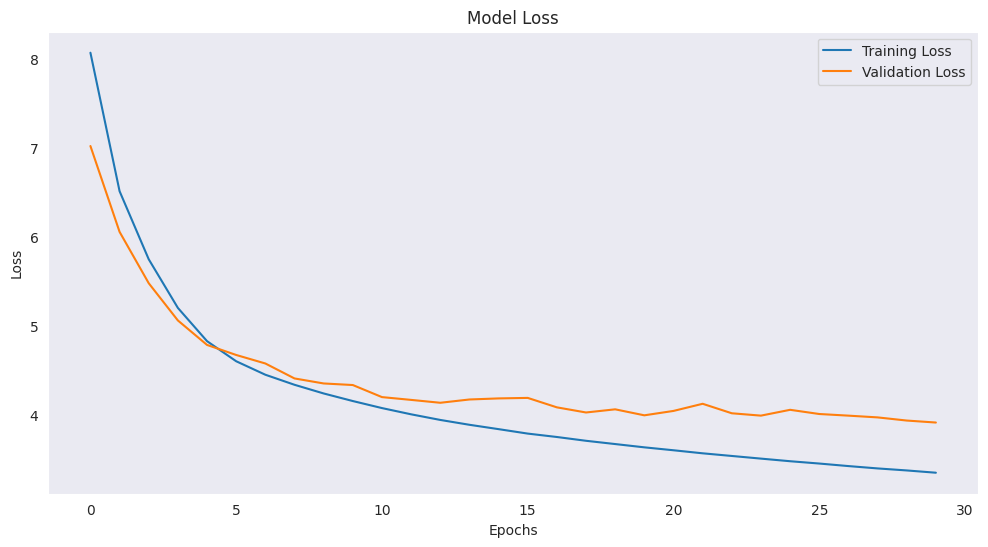

In [48]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 10. Generating Captions with Beam Search

defining helper functions to map indices to words and generate captions using a beam search strategy.This improves the quality of generated captions compared to greedy search.


In [60]:
# Function to map an index to its corresponding word in the tokenizer vocabulary
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def beam_search_predict(model, image, tokenizer, max_length, features, beam_index=3):
    feature = features[image]
    sequences = [[list(), 1.0]] # Start with an empty sequence and initial score 1.0

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq and seq[-1] == tokenizer.word_index['end']:
                all_candidates.append((seq, score))
                continue

            sequence = pad_sequences([seq], maxlen=max_length)
            y_pred = model.predict([feature, sequence], verbose=0)[0]  
            y_pred_indices = np.argsort(y_pred)[-beam_index:]  

            for word in y_pred_indices:
                candidate = [seq + [word], score * y_pred[word]]  
                all_candidates.append(candidate)

        
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)  
        sequences = ordered[:beam_index]

    return sequences

In [51]:
# Function to convert indices to words and filter out the "end" token
def generate_caption(sequence, tokenizer):
    caption = ' '.join([idx_to_word(i, tokenizer) for i in sequence if i > 0 and idx_to_word(i, tokenizer) != 'end'])
    return caption

## 11. Testing the Model on Sample Images

Taking a random sample of 15 images from the validation set and generate captions using our beam search method.
The generated captions are then visualized alongside the corresponding images.


In [52]:
# Take a random sample of 15 images from the test set
samples = val.sample(15)
samples.reset_index(drop=True, inplace=True)

In [53]:
# Loop through each sampled image and predict its caption
for index, record in samples.iterrows():
    caption_sequences = beam_search_predict(caption_model, record['image'], tokenizer, max_length, features)
    best_sequence = caption_sequences[0][0]  # Get the best sequence
    caption = generate_caption(best_sequence, tokenizer)  # Generate caption without "end" token
    samples.loc[index, 'caption'] = caption


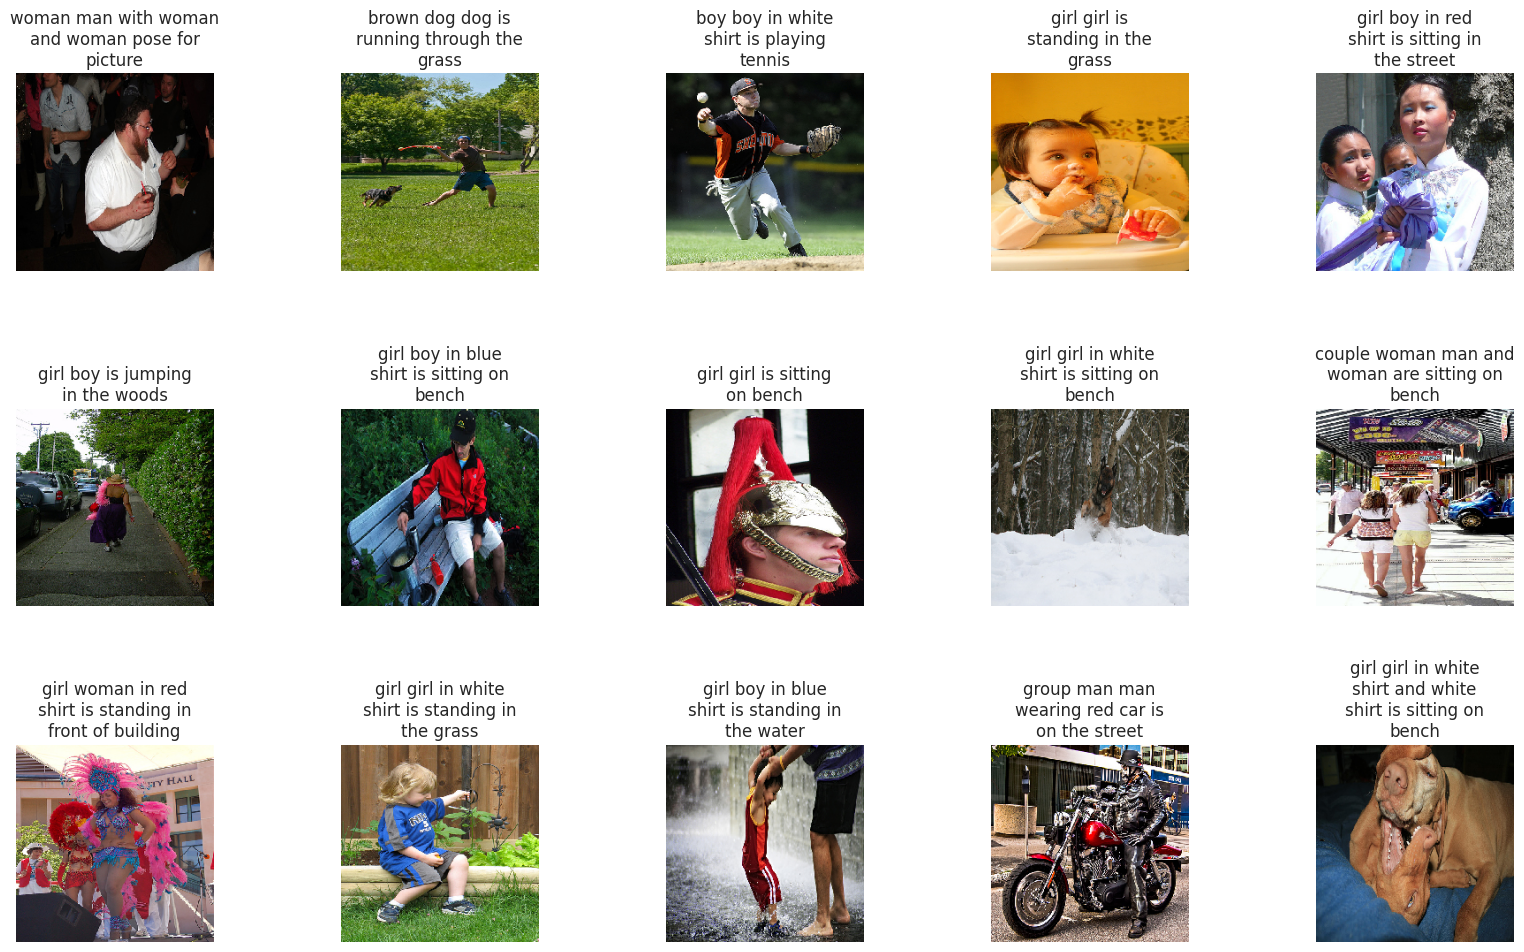

In [54]:
# Display the sampled images with their predicted captions
display_images(samples)


## 12. Saving the Model

In [55]:
# Save and serialize the trained model for inference
caption_model.save("/kaggle/working/caption_model.h5")

## 13. Fine-Tuning the Model

For additional performance, I unfreeze some layers of the base model and continue training.
Note the use of a reduced learning rate during fine-tuning.

In [56]:
# Fine-tuning the model
model.trainable = True  # Unfreeze the base model layers
for layer in model.layers[:143]:  # Freeze the first 143 layers
    layer.trainable = False

In [57]:
# Compile and continue training
caption_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy')  # Lower learning rate for fine-tuning
history_fine_tune = caption_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, earlystopping, lr_reduction]
)

Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 3.3384
Epoch 1: val_loss did not improve from 3.91578
474/474 ━━━━━━━━━━━━━━━━━━━━ 69s 137ms/step - loss: 3.3384 - val_loss: 4.1755 - learning_rate: 1.0000e-04
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 3.3218
Epoch 2: val_loss did not improve from 3.91578
474/474 ━━━━━━━━━━━━━━━━━━━━ 62s 130ms/step - loss: 3.3218 - val_loss: 3.9660 - learning_rate: 1.0000e-04
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 3.3057
Epoch 3: val_loss did not improve from 3.91578
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 137ms/step - loss: 3.3057 - val_loss: 4.0007 - learning_rate: 1.0000e-04
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 3.2754
Epoch 4: val_loss did not improve from 3.91578
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 139ms/step - loss: 3.2754 - val_loss: 4.0459 - learning_rate: 1.0000e-04
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 3.2443
Epoch 5: val_loss improved from 3.91578 to 

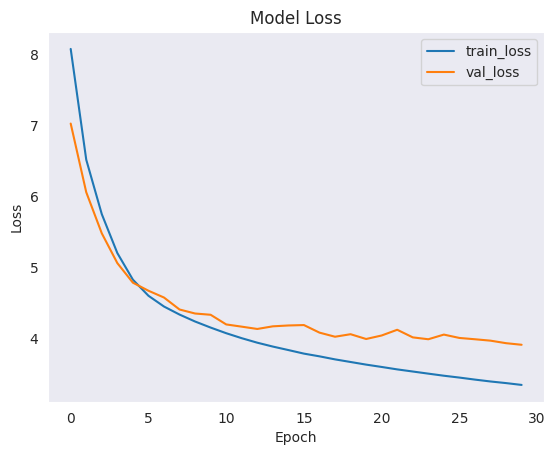

In [58]:
# Evaluate the model performance
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 14. Inference: Generating a Caption for a Single Image

Defining a simple function to generate a caption for any given image using the trained model.
This function demonstrates the end-to-end caption generation process.

In [61]:
# Function to generate captions for a given image
def generate_caption(image_path):
    # Load and preprocess the image
    img = readImage(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img_features = model.predict(img)  # Extract features using the pre-trained model

    # Start the caption generation process
    caption = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([img_features, sequence], verbose=0)
        yhat = np.argmax(yhat)  # Get the word with the highest probability
        word = tokenizer.index_word[yhat]  # Convert index to word
        if word is None:  # Stop if no word is found
            break
        caption += ' ' + word
        if word == 'end':  # Stop if the end token is generated
            break

    return caption.replace('start ', '').replace(' end', '')

# Example usage
sample_image_path = '/kaggle/working/flickr8k/Images/1001773457_577c3a7d70.jpg'  # Replace with an actual image path
generated_caption = generate_caption(sample_image_path)
print("Generated Caption:", generated_caption)

# Save the model for future use
caption_model.save('/kaggle/working/image_captioning_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Generated Caption: dog is running on the beach


## 15. Evaluation and Visualization on the Validation Set

In [63]:
# Load the model later if needed
import tensorflow as tf
from tensorflow.keras.models import load_model
def expand_dims_layer(x):
    return tf.expand_dims(x, axis=1)

loaded_model = load_model('/kaggle/working/image_captioning_model.h5',
                            custom_objects={'expand_dims_layer': expand_dims_layer})

def evaluate_model():
    total_loss = 0
    for i in range(len(val_generator)):
        x_val, y_val = val_generator[i]  # Unpack the inputs and targets
        val_loss = loaded_model.evaluate(x_val, y_val, verbose=0)
        total_loss += val_loss
    average_loss = total_loss / len(val_generator)
    print(f'Average Validation Loss: {average_loss}')

# Call the evaluation function
evaluate_model()

Average Validation Loss: 3.913153108162216


In [64]:
# Visualize some generated captions
def visualize_captions(images, captions):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(captions[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


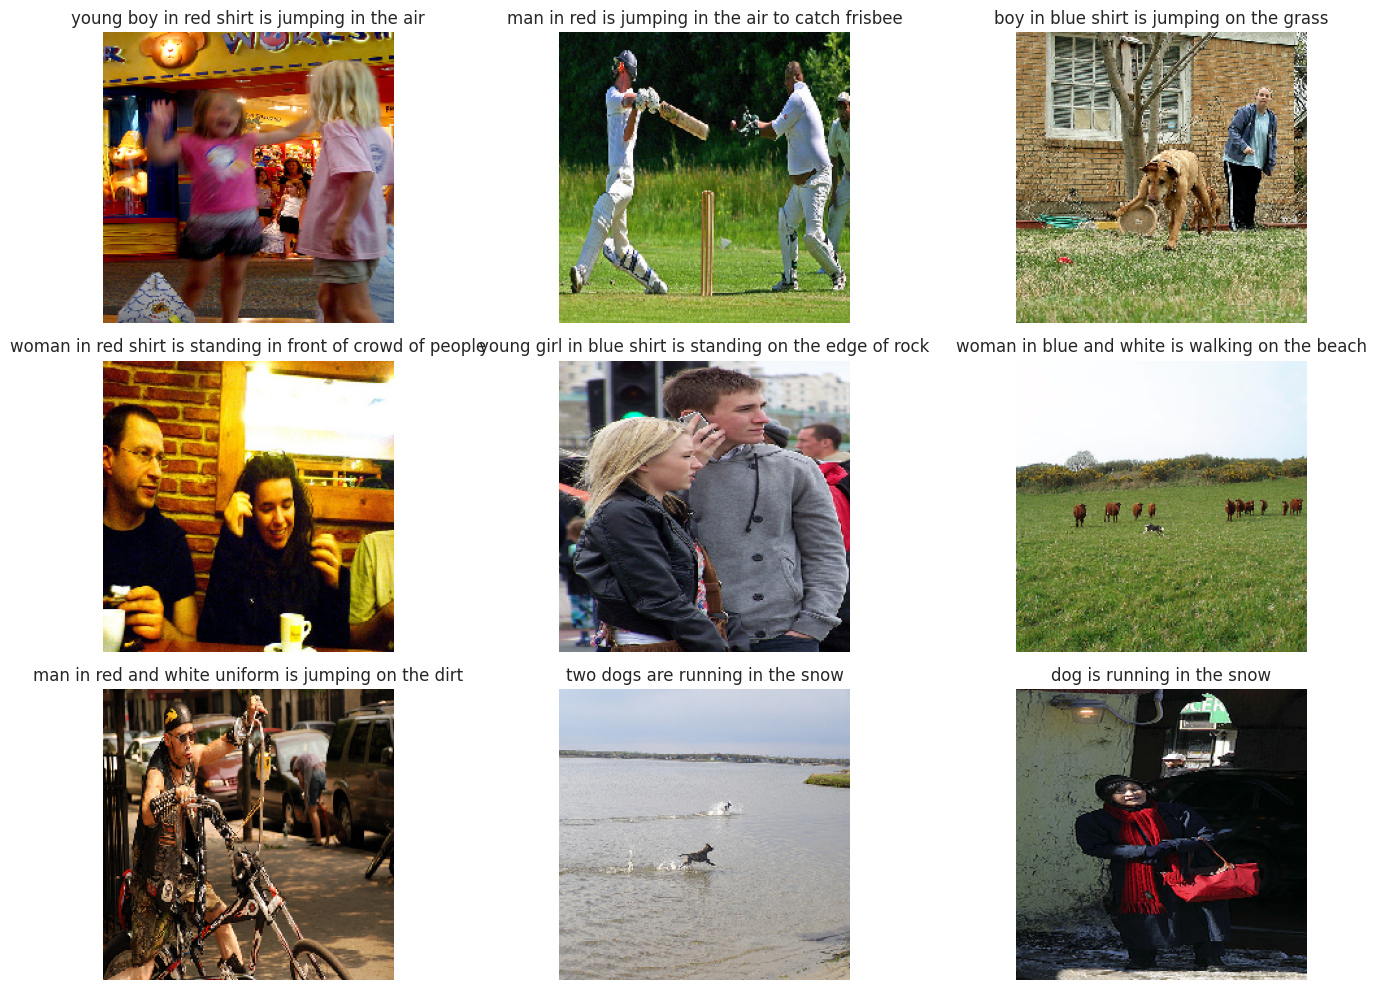

In [65]:
# Generate captions for a few validation images
sample_images = val['image'].sample(9).tolist()
sample_captions = [generate_caption(os.path.join(image_path, img)) for img in sample_images]
visualize_captions([readImage(os.path.join(image_path, img)) for img in sample_images], sample_captions)

## 16. Saving the tokenizer

In [66]:
# Save the tokenizer for future use
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Load the tokenizer later if needed
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)


## 17. Batch Caption Generation

In [67]:
# Function to generate captions for a batch of images
def generate_captions_for_batch(image_paths):
    captions = []
    for img_path in image_paths:
        caption = generate_caption(img_path)
        captions.append(caption)
    return captions

In [68]:
# Example usage for batch caption generation
batch_image_paths = val['image'].sample(5).tolist()
batch_generated_captions = generate_captions_for_batch([os.path.join(image_path, img) for img in batch_image_paths])
for img_path, caption in zip(batch_image_paths, batch_generated_captions):
    print(f"Image: {img_path}, Caption: {caption}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 3540241710_a4f49cde52.jpg, Caption: man in black shirt is standing on the sidewalk in front of building
Image: 408573233_1fff966798.jpg, Caption: boy in blue shirt is jumping in the air
Image: 3758175529_81941e7cc9.jpg, Caption: young boy in blue shirt is jumping on swing
Image: 438639005_208bc59b0b.jpg, Caption: dog is running in the snow
Image: 424506167_01f365726b.jpg, Caption: woman in blue shirt is standing on the grass with his dog


## 18. Saving Model Architecture and Weights Separately

In [71]:
# Save the model architecture and weights separately
caption_model.save_weights('/kaggle/working/image_captioning_model1.weights.h5')
with open('image_captioning_model.json', 'w') as json_file:
    json_file.write(caption_model.to_json())

## 19. Testing

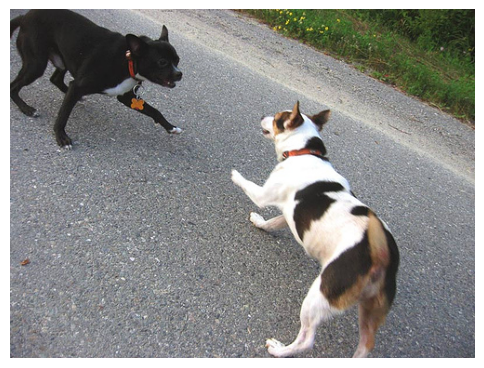

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image
img_path = "/kaggle/working/flickr8k/Images/1001773457_577c3a7d70.jpg"

# Read the image
img = mpimg.imread(img_path)

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()


In [74]:
# Function to evaluate the model on a specific image
def evaluate_single_image(image_path):
    caption = generate_caption(image_path)
    print(f"Generated Caption for {image_path}: {caption}")

# Example usage for evaluating a single image
evaluate_single_image('/kaggle/working/flickr8k/Images/1001773457_577c3a7d70.jpg')  # Replace with an actual image path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Generated Caption for /kaggle/working/flickr8k/Images/1001773457_577c3a7d70.jpg: dog is running on the beach


### The generated caption : *dog is running on the beach*

## 20. Deploying with Gradio

Finally, I create a Gradio interface to allow users to upload an image and receive a generated caption.
This interface can be launched locally or shared publicly.


In [6]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.0
    Uninstalling huggingface-hub-0.27.0:
      Successfully uninstalled huggingface-hub-0.27.0
Note: you may need to restart the kernel to use updated packages.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
from PIL import Image
import gradio as gr

# -----------------------------
# Model & Tokenizer Loading Functions
# -----------------------------

# If you used any custom layers, define them here
def expand_dims_layer(x):
    return tf.expand_dims(x, axis=1)

# Load the captioning model
caption_model = load_model("/kaggle/input/image_cap/tensorflow2/default/1/image_captioning_model.h5",
                           custom_objects={'expand_dims_layer': expand_dims_layer})

# Load the tokenizer
with open("/kaggle/input/image_tok/other/default/1/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load ResNet50 for feature extraction
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Set the maximum caption length (this should match what was used during training)
MAX_LENGTH = 35

# -----------------------------
# Preprocessing and Caption Generation Functions
# -----------------------------

def preprocess_image(image, target_size=224):
    """
    Resize and normalize the image.
    The input image is expected to be a PIL image.
    """
    image = image.resize((target_size, target_size))
    image = np.array(image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)  # add batch dimension
    return image

def generate_caption(image, resnet_model, caption_model, tokenizer, max_length=MAX_LENGTH):
    """
    Generate a caption for a given image.
    """
    # Preprocess the image and extract features using ResNet50
    image_preprocessed = preprocess_image(image)
    image_features = resnet_model.predict(image_preprocessed)
    
    # Start caption generation with the "start" token
    in_text = "start"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += " " + word
        if word == "end":
            break
    final_caption = in_text.split()[1:-1]  # remove "start" and "end" tokens
    return " ".join(final_caption)

# -----------------------------
# Gradio Interface Function
# -----------------------------

def gradio_generate_caption(image):
    """
    This function is called by Gradio.
    It receives a PIL image and returns the generated caption.
    """
    caption = generate_caption(image, resnet_model, caption_model, tokenizer, MAX_LENGTH)
    return caption

# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_generate_caption, 
    inputs=gr.Image(type="pil", label="Upload an Image"), 
    outputs="text",
    title="Image Captioning",
    description="Upload an image and the model will generate a caption for it."
)

# Launch the interface.
# In a Kaggle Notebook, this will output a public URL for testing.
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ce3ee57df6d626c65b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 35, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
